Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import zipfile
import PIL
from glob import glob
import tensorflow as tf
import shutil
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


In [3]:
# Unzip all the files uploaded on gdrive
zip_path = '/content/gdrive/MyDrive/CNN_assignment.zip'
# Create a destination directory
extract_path = '/content/dataset/'
os.makedirs(extract_path, exist_ok=True)
# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Files extracted to:", extract_path)

Files extracted to: /content/dataset/


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    color_mode = 'rgb',
    subset = 'training',
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    color_mode = 'rgb',
    subset = 'validation',
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

/content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0031922.jpg
/content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/ISIC_0028106.jpg
/content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/ISIC_0033790.jpg
/content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0010089.jpg
/content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/ISIC_0000080.jpg
/content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/ISIC_0026524.jpg
/content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/ISIC_0011094.jpg
/content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/ISIC_0025831.jpg
/content/dataset/Skin cancer ISIC The Inter

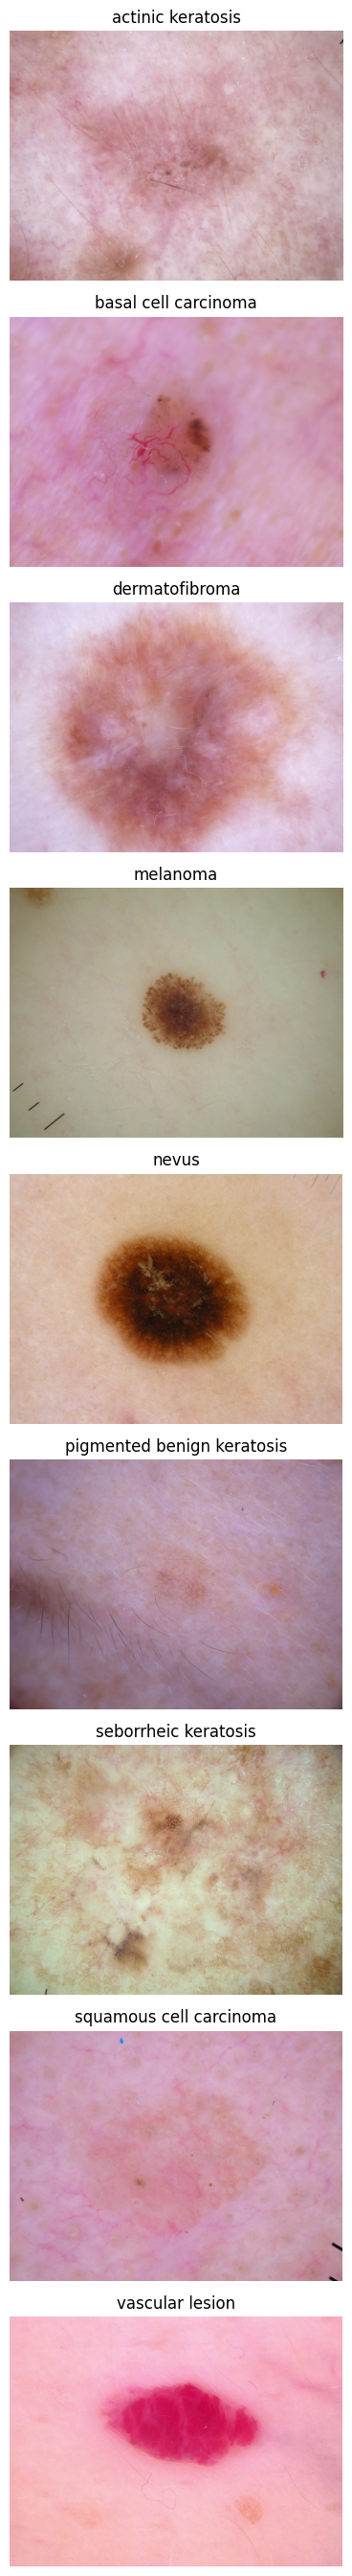

In [10]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

# Dictionary to store 1 image path for each class
class_images = {}
# Store one image per class in the dictionary
for class_name in class_names:
    class_dir = os.path.join(data_dir_train, class_name)
    image_files = os.listdir(class_dir)
    image_path = os.path.join(class_dir, image_files[0])
    class_images[class_name] = image_path
# Plot the images
plt.figure(figsize=(6, len(class_images) * 3))
for idx, (class_name, image_path) in enumerate(class_images.items()):
    img = plt.imread(image_path)
    print(image_path)
    plt.subplot(len(class_images), 1, idx + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')
plt.tight_layout()
plt.show()


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [29]:
### Your code goes here
model = Sequential()
model.add(layers.Rescaling(scale=1.0 / 255, input_shape=(img_height, img_width, 3)))

# first conv layer
model.add(layers.Conv2D(32, kernel_size=(3, 3),
                 padding='same',
                 activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# second conv layer
model.add(layers.Conv2D(64, kernel_size=(3, 3),
                 padding='same',
                 activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# third conv layer
model.add(layers.Conv2D(128, kernel_size=(3, 3),
                 padding='same',
                 activation='relu'))
model.add(layers.AveragePooling2D(pool_size=(2, 2)))

# flatten and put a fully connected layer
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu')) # fully connected

# softmax layer
num_classes = 9
model.add(layers.Dense(num_classes, activation='softmax'))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [30]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [31]:
# View the summary of all layers
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      31,719,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,817,801 (121.38 MB)

 Trainable params: 31,817,801 (121.38 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [32]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 204s 3s/step - accuracy: 0.1816 - loss: 3.1138 - val_accuracy: 0.3154 - val_loss: 1.9032
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 176s 3s/step - accuracy: 0.3584 - loss: 1.8048 - val_accuracy: 0.4430 - val_loss: 1.5770
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 220s 3s/step - accuracy: 0.4526 - loss: 1.5484 - val_accuracy: 0.4855 - val_loss: 1.5290
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 179s 3s/step - accuracy: 0.5006 - loss: 1.4122 - val_accuracy: 0.5190 - val_loss: 1.4404
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 204s 3s/step - accuracy: 0.5446 - loss: 1.2792 - val_accuracy: 0.4877 - val_loss: 1.4501
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 209s 3s/step - accuracy: 0.5559 - loss: 1.1995 - val_accuracy: 0.5213 - val_loss: 1.4976
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 182s 3s/step - accuracy: 0.6245 - loss: 1.0741 - val_accuracy: 0.5548 - val_loss: 1.4303
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 0.6562 - loss: 0.9822 - val_accuracy: 0.5078 - v

### Visualizing training results

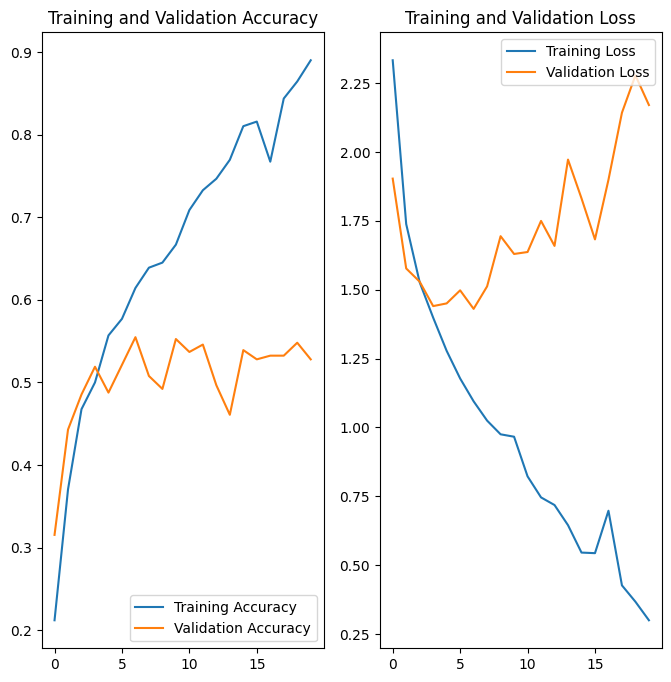

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### We can clearly see that the model is overfitting as there is a huge difference between the training accuracy and the valdation accuracy and also the training accuracy is higher than validation accuracy at the end of model training. Also the training loss has decreased whereas the validation accuracy decreases first and then again increases during model training.

In [40]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Applying random rotation and random zoom as part of augmentation to the training dataset
data_augmentation = Sequential([
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.05)
])

In [41]:
print(class_name)

melanoma


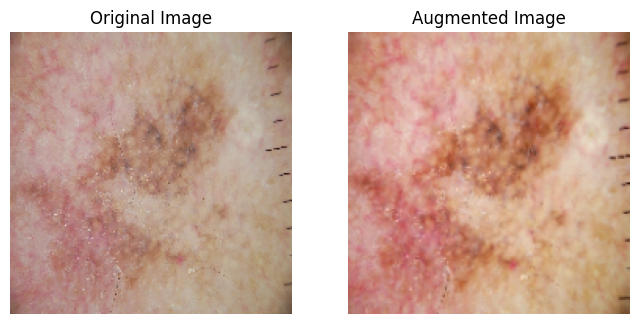

In [42]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
# We will visualize the augmented image belonging to melanoma class alongside its original image
class_name = "melanoma"
img_path = class_images[class_name]
img = keras.utils.load_img(img_path, target_size=(180, 180))  # Resize image
img_array = keras.utils.img_to_array(img)  # Convert to array
img_array = tf.expand_dims(img_array, axis=0)  # Add batch dimension

# Apply augmentation
augmented_img = data_augmentation(img_array)

# Visualize both original and augmented images
plt.figure(figsize=(8, 4))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(tf.keras.utils.array_to_img(img_array[0]))
plt.title("Original Image")
plt.axis('off')

# Augmented Image
plt.subplot(1, 2, 2)
plt.imshow(tf.keras.utils.array_to_img(augmented_img[0]))
plt.title("Augmented Image")
plt.axis('off')

plt.show()

### Todo:
### Create the model, compile and train the model


In [43]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = Sequential()
## Applying augmentation to all the images in training dataset below
model.add(data_augmentation)
model.add(layers.Rescaling(scale=1.0 / 255, input_shape=(img_height, img_width, 3)))

# first conv layer
model.add(layers.Conv2D(32, kernel_size=(3, 3),
                 padding='same',
                 activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# second conv layer
model.add(layers.Conv2D(64, kernel_size=(3, 3),
                 padding='same',
                 activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Dropout(0.20))

# third conv layer
model.add(layers.Conv2D(128, kernel_size=(3, 3),
                 padding='same',
                 activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Dropout(0.20))


# flatten and put a fully connected layer
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu')) # fully connected
model.add(layers.Dropout(0.5))

# softmax layer
num_classes = 9
model.add(layers.Dense(num_classes, activation='softmax'))



### Compiling the model

In [44]:
## Your code goes here
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [45]:
# View the summary of all layers
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_6 (Sequential)            │ (1, 180, 180, 3)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (1, 180, 180, 3)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (1, 180, 180, 32)           │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (1, 90, 90, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (1, 90, 90, 64)             │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (1, 45, 45, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (1, 45, 45, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (1, 45, 45, 128)            │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (1, 22, 22, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (1, 22, 22, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (1, 61952)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (1, 512)                    │      31,719,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (1, 512)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (1, 9)                      │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,817,801 (121.38 MB)

 Trainable params: 31,817,801 (121.38 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [46]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 191s 3s/step - accuracy: 0.1675 - loss: 4.8289 - val_accuracy: 0.1924 - val_loss: 2.0730
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 203s 3s/step - accuracy: 0.2030 - loss: 2.0468 - val_accuracy: 0.2058 - val_loss: 2.0414
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 200s 3s/step - accuracy: 0.2003 - loss: 2.0365 - val_accuracy: 0.3378 - val_loss: 1.8691
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 186s 3s/step - accuracy: 0.3138 - loss: 1.8557 - val_accuracy: 0.4161 - val_loss: 1.6530
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 204s 3s/step - accuracy: 0.3847 - loss: 1.7074 - val_accuracy: 0.4519 - val_loss: 1.5710
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 189s 3s/step - accuracy: 0.4343 - loss: 1.5789 - val_accuracy: 0.4340 - val_loss: 1.5649
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 203s 3s/step - accuracy: 0.4710 - loss: 1.5311 - val_accuracy: 0.4609 - val_loss: 1.5653
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 203s 3s/step - accuracy: 0.5284 - loss: 1.4075 - val_accuracy: 0.4653 - v

### Visualizing the results

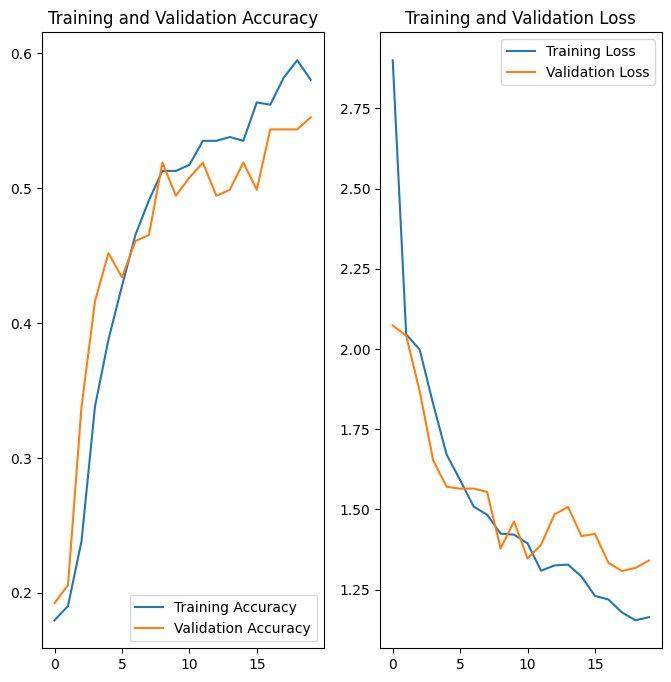

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### The validation accuracy of the model has increased by a small value in comparison to first model's validation accuracy but the model's training accuracy has decreased by a significant amount in comparison to the first model. Since the training accuracy and validation accuracy both are in 50's so we can say that the model is underfitting and hence we cannot say that the model has improved in comparison to the previous model.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [12]:
## Your code goes here.
## Iterate through all the classes and print the number of training images each class contains
for class_name in class_names:
    class_dir = os.path.join(data_dir_train, class_name)
    print(f"Total number of training image for {class_name} is ", len(os.listdir(class_dir)))

Total number of training image for actinic keratosis is  114
Total number of training image for basal cell carcinoma is  376
Total number of training image for dermatofibroma is  95
Total number of training image for melanoma is  438
Total number of training image for nevus is  357
Total number of training image for pigmented benign keratosis is  462
Total number of training image for seborrheic keratosis is  77
Total number of training image for squamous cell carcinoma is  181
Total number of training image for vascular lesion is  139


#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Seborrheic Keratosis class has the least number of samples
#### - Which classes dominate the data in terms proportionate number of samples?
#### - Pigmented Benign Keratosis dominates the data

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [13]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [14]:
path_to_training_dataset="/content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7D6D480BB700>: 100%|██████████| 500/500 [00:21<00:00, 23.64 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D6D480BB280>: 100%|██████████| 500/500 [00:24<00:00, 20.35 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7D6D48257670>: 100%|██████████| 500/500 [00:19<00:00, 26.02 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7D6D4813B7C0>: 100%|██████████| 500/500 [01:33<00:00,  5.34 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7D6D480B46A0>: 100%|██████████| 500/500 [01:31<00:00,  5.49 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7D6D4817F4C0>: 100%|██████████| 500/500 [00:18<00:00, 27.71 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7D6D48164370>: 100%|██████████| 500/500 [00:40<00:00, 12.44 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D6D48386350>: 100%|██████████| 500/500 [00:17<00:00, 29.29 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D6D480B9270>: 100%|██████████| 500/500 [00:18<00:00, 27.78 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [15]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [16]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010770.jpg_552cec6b-9df4-4fc5-8152-243a053f921b.jpg',
 '/content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010364.jpg_8f64522b-c89e-4a52-a2b0-d7258097b2da.jpg',
 '/content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010543.jpg_6293538f-b806-4d02-b2f1-a49a9bb3d599.jpg',
 '/content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010550.jpg_c0a34bf9-00be-4591-91c7-aa707dfe6d1d.jpg',
 '/content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0001128.jpg_71af77c3-2d92-4980-be8f-59dd84fabafd.jpg',
 '/content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma

In [17]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [18]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [19]:
''' The dictionary named dataframe_dict_new contains all the file paths of the augmented images as the key and
class name as the value '''
dataframe_dict_new

{'/content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010770.jpg_552cec6b-9df4-4fc5-8152-243a053f921b.jpg': 'melanoma',
 '/content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010364.jpg_8f64522b-c89e-4a52-a2b0-d7258097b2da.jpg': 'melanoma',
 '/content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010543.jpg_6293538f-b806-4d02-b2f1-a49a9bb3d599.jpg': 'melanoma',
 '/content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010550.jpg_c0a34bf9-00be-4591-91c7-aa707dfe6d1d.jpg': 'melanoma',
 '/content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0001128.jpg_71af77c3-2d92-4980-be8f-59dd84fabafd.jpg': 'melanoma',
 '/content/dataset/Skin cancer ISIC

In [20]:
new_df = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [21]:
new_df.shape

(4500, 2)

In [22]:
## Checking the number of augmented images belonging to each class
new_df['Label'].value_counts()

,count
Label,
melanoma,500
dermatofibroma,500
vascular lesion,500
actinic keratosis,500
basal cell carcinoma,500
squamous cell carcinoma,500
nevus,500
seborrheic keratosis,500
pigmented benign keratosis,500


In [23]:
path_list_original = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list_original)

2239

In [24]:
lesion_list_original = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(lesion_list_original)

2239

In [25]:
dataframe_dict_original = dict(zip(path_list_original, lesion_list_original))
''' The dictionary named dataframe_dict_original contains all the file paths of the augmented images as the key and
class name as the value '''
dataframe_dict_original

{'/content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0010089.jpg': 'melanoma',
 '/content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0011094.jpg': 'melanoma',
 '/content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0010978.jpg': 'melanoma',
 '/content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0000288.jpg': 'melanoma',
 '/content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0010164.jpg': 'melanoma',
 '/content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0010441.jpg': 'melanoma',
 '/content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0000434.jpg': 'melanoma',
 '/content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0000312.jp

In [26]:
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])

In [27]:
## Checking the number of original images belonging to each class
original_df['Label'].value_counts()

,count
Label,
pigmented benign keratosis,462
melanoma,438
basal cell carcinoma,376
nevus,357
squamous cell carcinoma,181
vascular lesion,139
actinic keratosis,114
dermatofibroma,95
seborrheic keratosis,77


In [28]:
combined_df = pd.concat([original_df,new_df])

In [29]:
combined_df['Label'].value_counts()

,count
Label,
pigmented benign keratosis,962
melanoma,938
basal cell carcinoma,876
nevus,857
squamous cell carcinoma,681
vascular lesion,639
actinic keratosis,614
dermatofibroma,595
seborrheic keratosis,577


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Move the augmented images from output subdirectory to respective class directories

In [30]:
base_dir= "/content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
os.listdir(base_dir)

['melanoma',
 'dermatofibroma',
 'vascular lesion',
 'actinic keratosis',
 'basal cell carcinoma',
 'squamous cell carcinoma',
 'nevus',
 'seborrheic keratosis',
 'pigmented benign keratosis']

In [31]:
base_dir = "/content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
for class_dir in os.listdir(base_dir):
    class_path = os.path.join(base_dir, class_dir)
    output_path = os.path.join(class_path, "output")

    # If 'output' directory exists, move its contents to the parent directory
    if os.path.exists(output_path):
        for file_name in os.listdir(output_path):
            shutil.move(os.path.join(output_path, file_name), class_path)
        os.rmdir(output_path)  # Remove the empty 'output' directory

#### **Todo**: Train the model on the data created using Augmentor

In [32]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [33]:
data_dir_train=base_dir
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [34]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [35]:
## your code goes here
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = Sequential()
model.add(layers.Rescaling(scale=1.0 / 255, input_shape=(img_height, img_width, 3)))

# first conv layer
model.add(layers.Conv2D(32, kernel_size=(3, 3),
                 padding='same',
                 activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# second conv layer
model.add(layers.Conv2D(64, kernel_size=(3, 3),
                 padding='same',
                 activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Dropout(0.20))

# third conv layer
model.add(layers.Conv2D(64, kernel_size=(3, 3),
                 padding='same',
                 activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Dropout(0.20))

# fourth conv layer
model.add(layers.Conv2D(128, kernel_size=(3, 3),
                 padding='same',
                 activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Dropout(0.20))


# flatten and put a fully connected layer
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu')) # fully connected
model.add(layers.Dropout(0.5))

# softmax layer
num_classes = 9
model.add(layers.Dense(num_classes, activation='softmax'))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [36]:
## Your code goes here
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [37]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 90, 90, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 22, 22, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 22, 22, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 11, 11, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 11, 11, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 15488)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       7,930,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,065,929 (30.77 MB)

 Trainable params: 8,065,545 (30.77 MB)

 Non-trainable params: 384 (1.50 KB)

#### **Todo:**  Train your model

In [38]:
epochs = 50
# Using early stopping parameter for stopping the model training earlier if there is no improvement in validation accuracy
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stopping]
)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 513s 3s/step - accuracy: 0.2601 - loss: 6.2033 - val_accuracy: 0.1151 - val_loss: 19.2470
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 557s 3s/step - accuracy: 0.3808 - loss: 1.6631 - val_accuracy: 0.1908 - val_loss: 12.1975
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 566s 3s/step - accuracy: 0.4215 - loss: 1.5468 - val_accuracy: 0.4098 - val_loss: 3.0471
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 565s 3s/step - accuracy: 0.4356 - loss: 1.4660 - val_accuracy: 0.3831 - val_loss: 2.7210
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 550s 3s/step - accuracy: 0.4656 - loss: 1.4319 - val_accuracy: 0.4774 - val_loss: 1.7411
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 518s 3s/step - accuracy: 0.5101 - loss: 1.3016 - val_accuracy: 0.3860 - val_loss: 1.9156
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 547s 3s/step - accuracy: 0.5153 - loss: 1.2829 - val_accuracy: 0.2138 - val_loss: 6.7039
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 499s 3s/step - accuracy: 0.5663 - loss: 1.1500 - val_ac

In [60]:
best_epoch = early_stopping.stopped_epoch - early_stopping.patience + 1
training_accuracy = history.history['accuracy'][best_epoch-1]
validation_accuracy = history.history['val_accuracy'][best_epoch-1]
print(f"The best model was obtained at epoch number {best_epoch}")
print(f"Training accuracy: {training_accuracy}")
print(f"Validation accuracy: {validation_accuracy}")

The best model was obtained at epoch number 34
Training accuracy: 0.8762982487678528
Validation accuracy: 0.8440979719161987


### The model was only trained till epoch number 44 because of early stopping and the best model with the highest validation accuracy was obtained at epoch 34

#### **Todo:**  Visualize the model results

In [56]:
print(epochs_range)

range(0, 34)


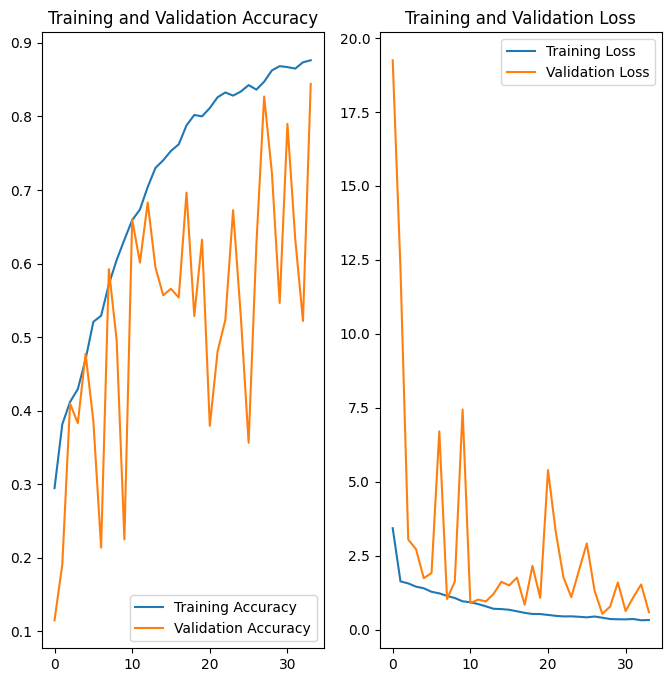

In [58]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(best_epoch)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc[:best_epoch], label='Training Accuracy')
plt.plot(epochs_range, val_acc[:best_epoch], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss[:best_epoch], label='Training Loss')
plt.plot(epochs_range, val_loss[:best_epoch], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



### The model that we obtained after training by using augmented images is a good one which is neither underfit nor overfit. The class rebalance helped in achieving a good accuracy. The training accuracy obtained for the best model is approx 87% and validation accuracy obtained for the best model is approx 84%.